In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import config
import api_rxnorm
import DatasetCreation

# Load Data

In [6]:
dir = '../data/'
prefix = 'FONNESBECK_'
suffix = '_20151202.csv'

In [9]:
adt = pd.read_csv(dir + prefix + 'ADT' + suffix, encoding='latin1')
adt.columns = adt.columns.str.lower()
adt.head()

,ruid,event,admission_date,event_date,srv_code,chief_complaint,discharge_date
0,50135262,Admit,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
1,50135262,Transfer,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
2,50135262,Transfer,02/08/2007,02/09/2007,ORT,R FEMUR FX,02/12/2007
3,50135262,Discharge,02/08/2007,02/12/2007,ORT,R FEMUR FX,02/12/2007
4,50135262,Transfer,02/11/2011,02/11/2011,NEU,SEIZURES;HYPERGLYCEMIA,02/23/2011


In [8]:
bmi = pd.read_csv(dir + prefix + 'BMI' + suffix)
bmi.columns = bmi.columns.str.lower()
bmi.head()

,ruid,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,41.43,01/09/2005,119.98,170.18,0
1,50135262,22.86,02/11/2011,70.00,175.00,0
2,50135262,43.07,02/12/2011,131.90,175.00,0
3,50135262,43.06,02/12/2011,131.86,175.00,0
4,50135262,41.47,02/12/2011,127.00,175.00,0


In [9]:
bp = pd.read_csv(dir + prefix + 'BP' + suffix)
bp.columns = bp.columns.str.lower()
bp.head()

,ruid,systolic,diastolic,measure_date
0,50135262,150,80,01/09/2005
1,50135262,137,77,02/08/2007
2,50135262,137,78,02/08/2007
3,50135262,190,78,02/08/2007
4,50135262,190,77,02/08/2007


In [7]:
cpt = pd.read_csv(dir + prefix + 'CPT' + suffix)
cpt.columns = cpt.columns.str.lower()
cpt.head()

,ruid,cpt_code,event_date
0,50135262,00001,11/28/2004
1,50135262,00005,05/03/2012
2,50135262,00025,02/08/2007
3,50135262,00025,11/16/2004
4,50135262,00030,02/08/2007


In [119]:
egfr = pd.read_csv(dir + prefix + 'EGFR' + suffix)
egfr.columns = egfr.columns.str.lower()
egfr.head()

,ruid,egfr,egfr_date
0,50135262,123.68000,02/08/2007
1,50135262,123.67783,02/08/2007
2,50135262,76.40173,02/11/2011
3,50135262,76.40000,02/11/2011
4,50135262,78.64000,02/12/2011


In [6]:
icd = pd.read_csv(dir + prefix + 'ICD9' + suffix, parse_dates=['Event_date'])
icd.columns = icd.columns.str.lower()
icd.head()

,ruid,icd9_code,event_date
0,50135262,00.40,2007-08-04
1,50135262,00.46,2007-08-04
2,50135262,00.66,2007-08-04
3,50135262,00.81,2012-09-17
4,50135262,00.82,2012-09-17


In [0]:
# can't get this to work (Alvin)
# I have no trouble opening it in R
#library(data.table)
#df <- fread('/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB_20151202.csv')
#write.csv(df, file = '/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB2_20151202.csv')

#lab = pd.read_csv(dir + prefix + 'LAB' + suffix) # engine='python' produces a different error
#lab.head()

In [120]:
lab = pd.read_csv(dir + prefix + 'LAB2' + suffix)
lab.columns = lab.columns.str.lower()
lab.head()

,unnamed: 0,ruid,lab_name,lab_date,lab_value
0,1,50135262,%SAT,04/13/2008,17
1,2,50135262,ABO,02/08/2007,A
2,3,50135262,ABO,02/24/2008,a
3,4,50135262,AN-GAP,02/08/2007,9
4,5,50135262,AN-GAP,02/11/2011,8


In [5]:
med = pd.read_csv(dir + prefix + 'MED' + suffix) # parse dates took a long time to load
med.columns = med.columns.str.lower()
med.head()

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
0,50135262,02/13/2011,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650.00000 MG,Q4H PRN,NaN
1,50135262,05/23/2012,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN
2,50135262,05/23/2012,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650.00000 MG,Q4H PRN,NaN
3,50135262,10/29/2010,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,ONCE,NaN
4,50135262,10/29/2010,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650.00000 MG,ONCE,NaN


In [38]:
phenotype = pd.read_csv(dir + prefix + 'phenotype' + suffix, parse_dates=['DOB', 'DOD'])
phenotype.columns = phenotype.columns.str.lower()
phenotype.head()

,ruid,sex,dob,dod,race
0,50135262,F,1949-09-20,NaT,W
1,50135361,M,1932-02-15,2012-09-09,W
2,50135369,M,1958-05-04,2012-01-23,W
3,50135375,M,1943-05-01,2011-08-18,B
4,50135425,F,1946-10-02,NaT,W


# Phenotype

In [39]:
phenotype.describe(include='all')

,ruid,sex,dob,dod,race
count,8.000000e+03,7957,7957,1358,8000
unique,NaN,3,7049,1119,7
top,NaN,F,1955-03-06 00:00:00,2014-02-22 00:00:00,W
freq,NaN,3986,4,5,5999
first,NaN,NaN,1903-04-17 00:00:00,2004-08-19 00:00:00,NaN
last,NaN,NaN,2014-11-15 00:00:00,2015-06-25 00:00:00,NaN
mean,5.369131e+07,NaN,NaN,NaN,NaN
std,3.663645e+05,NaN,NaN,NaN,NaN
min,5.013526e+07,NaN,NaN,NaN,NaN
25%,5.372991e+07,NaN,NaN,NaN,NaN


In [40]:
uniq = len(np.unique(phenotype.ruid))

print("Shape of phenotype = {shape}. Unique RUIDs = {uniq}.".format(
    shape=phenotype.shape, uniq=uniq))

Shape of phenotype = (8000, 5). Unique RUIDs = 8000.


In [41]:
females = sum(phenotype.sex=='F')
males = sum(phenotype.sex=='M')
unknown = sum(phenotype.sex=='U')
miss = phenotype.sex.isnull().sum()
assert(females + males + unknown + miss == uniq)

print("Females = {f}, Males = {m}, Unknown = {u}, NA = {na}".format(
  f=females, m=males, u=unknown, na=miss))

Females = 3986, Males = 3953, Unknown = 18, NA = 43


In [31]:
def pie_chart(labels, df, var, title, font=14, figsize=(2, 2)):
  """
  Create pie chart of categorical variables.
  Inpute: labels (as a list), var - column from dataframe, title for figure
  """
  sizes = []
  for lab in labels: 
      sizes.append(len(df[df[var] == lab]))
  fig1, ax1 = plt.subplots()
  font = {'family' : 'monospace',
          'size'   : font}
  plt.rcParams["figure.figsize"] = figsize
  plt.rc('font', **font) 
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=0.8, startangle=90)
  ax1.axis('equal'); ax1.set_title(title, y=1.08); plt.show()

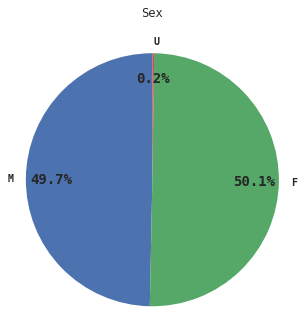

In [51]:
pie_chart(['M', 'F', 'U'], phenotype, 'sex', 'Sex')

In [52]:
asian = sum(phenotype.race=='A')
black = sum(phenotype.race=='B')
hispanic = sum(phenotype.race=='H')
indian = sum(phenotype.race=='I')
other = sum(phenotype.race=='N')
unknown = sum(phenotype.race=='U')
white = sum(phenotype.race=='W')
assert(asian + black + hispanic + indian + other + unknown + white == uniq)

print("Asian = {a}, Black = {b}, Hispanice = {h}, American Indian = {i}, Other = {n}, Unknown = {u}, White = {w}".format( \
  a=asian, b=black, h=hispanic, i=indian, n=other, u=unknown, w=white))

Asian = 94, Black = 1193, Hispanice = 315, American Indian = 8, Other = 50, Unknown = 341, White = 5999


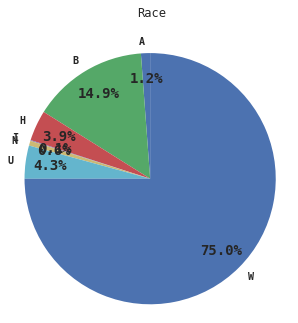

In [55]:
pie_chart(['A', 'B', 'H', 'I', 'N', 'U', 'W'], phenotype, 'race', 'Race', figsize=(5, 5))

In [117]:
# missing DOB or sex
potential_removal = phenotype[phenotype.dob.isnull() | phenotype.sex.isnull()]
potential_removal

,ruid,sex,dob,dod,race
138,53727820,NaN,NaT,NaT,U
363,53728072,NaN,NaT,NaT,U
537,53728274,NaN,NaT,NaT,U
711,53728472,NaN,NaT,NaT,U
811,53728579,NaN,NaT,NaT,U
832,53728602,NaN,NaT,NaT,U
906,53728684,NaN,NaT,NaT,U
955,53728740,NaN,NaT,NaT,U
1192,53729008,NaN,NaT,NaT,U
1318,53729141,NaN,NaT,NaT,U


In [224]:
potential_removal.shape

(43, 5)

### Should we remove these patients with missing DOB? 

# ICD Codes

In [7]:
icd.tail()

,ruid,icd9_code,event_date
2052062,53736423,77,2006-04-25
2052063,53736423,774.6,2006-04-23
2052064,53736423,V30.00,2006-04-23
2052065,53736423,V50.2,2006-04-23
2052066,53736423,V50.2,2006-04-24


In [8]:
uniq = len(np.unique(icd.ruid))
codes = set(icd.icd9_code)

print("Shape of ICD = {shape}. Unique RUIDs = {uniq}. Unique ICD9 Codes = {codes}.".format(
    shape=icd.shape, uniq=uniq, codes=len(codes)))

Shape of ICD = (2052067, 3). Unique RUIDs = 7935. Unique ICD9 Codes = 12423.


In [0]:
icd2 = icd.copy()

In [10]:
# create a new column of numeric version of codes, making strings NaN
icd2['code_num'] = pd.to_numeric(icd2.icd9_code, errors='coerce')
icd2.tail()

,ruid,icd9_code,event_date,code_num
2052062,53736423,77,2006-04-25,77.0
2052063,53736423,774.6,2006-04-23,774.6
2052064,53736423,V30.00,2006-04-23,NaN
2052065,53736423,V50.2,2006-04-23,NaN
2052066,53736423,V50.2,2006-04-24,NaN


In [0]:
icd2['code_cat'] = pd.cut(icd2.code_num, bins=[0, 1, 140, 240, 280, 290, 320, 
                                              390, 460, 520, 580, 630, 
                                              680, 710, 740, 760, 780, 800, 1000], 
                          right=False, # closed on the left, non-inclusive on the right
                          labels=['proc', 'dx_infection', 'dx_neoplasm', 'dx_endocrine', 'dx_blood', 'dx_mental', 'dx_nervous', 
                                 'dx_circulatory', 'dx_respiratory', 'dx_digestive', 'dx_gu', 'dx_obstetric', 
                                 'dx_skin', 'dx_muscskel', 'dx_congenital', 'dx_perinatal', 'dx_symptoms', 'dx_injury'])

icd2.code_cat = np.where(icd2.icd9_code.str.contains('V'), 'visit', icd2.code_cat)
icd2.code_cat = np.where(icd2.icd9_code.str.contains('E'), 'dx_external', icd2.code_cat)

In [12]:
icd2.head()

,ruid,icd9_code,event_date,code_num,code_cat
0,50135262,00.40,2007-08-04,0.40,proc
1,50135262,00.46,2007-08-04,0.46,proc
2,50135262,00.66,2007-08-04,0.66,proc
3,50135262,00.81,2012-09-17,0.81,proc
4,50135262,00.82,2012-09-17,0.82,proc


In [13]:
icd2.tail()

,ruid,icd9_code,event_date,code_num,code_cat
2052062,53736423,77,2006-04-25,77.0,dx_infection
2052063,53736423,774.6,2006-04-23,774.6,dx_perinatal
2052064,53736423,V30.00,2006-04-23,NaN,visit
2052065,53736423,V50.2,2006-04-23,NaN,visit
2052066,53736423,V50.2,2006-04-24,NaN,visit


### More spot-checking needed to ensure these were cut correctly

In [0]:
dx_dict = {}
for dx in set(icd2.code_cat):
  dx_dict[dx] = sum(icd2.code_cat==str(dx))

assert(sum(dx_dict.values()) == icd.shape[0])

In [15]:
dx_dict

{'dx_blood': 76572,
 'dx_circulatory': 226565,
 'dx_congenital': 34379,
 'dx_digestive': 87582,
 'dx_endocrine': 162164,
 'dx_external': 13521,
 'dx_gu': 95505,
 'dx_infection': 145279,
 'dx_injury': 78319,
 'dx_mental': 79404,
 'dx_muscskel': 100649,
 'dx_neoplasm': 108924,
 'dx_nervous': 86283,
 'dx_obstetric': 19746,
 'dx_perinatal': 24061,
 'dx_respiratory': 109354,
 'dx_skin': 26707,
 'dx_symptoms': 283718,
 'proc': 38203,
 'visit': 255132}

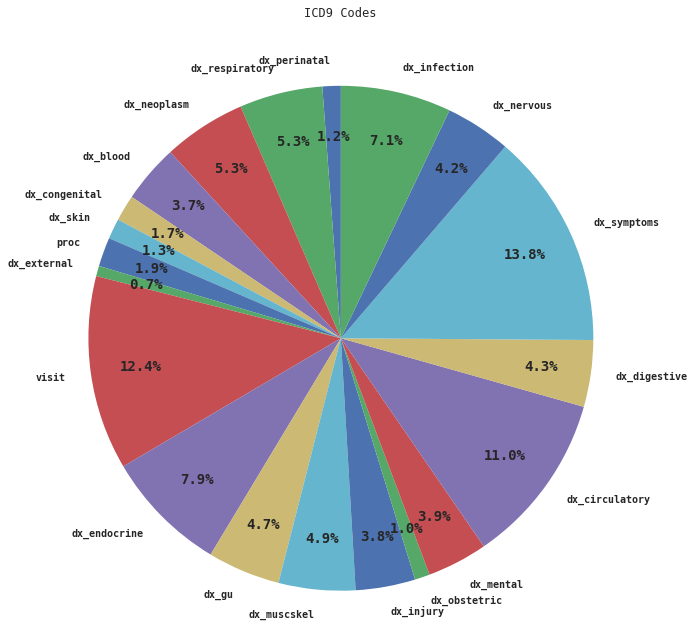

In [58]:
pie_chart(dx_dict.keys(), icd2, 'code_cat', 'ICD9 Codes', figsize = (10, 10))

In [60]:
icd2.head()

,ruid,icd9_code,event_date,code_num,code_cat
0,50135262,00.40,2007-08-04,0.40,proc
1,50135262,00.46,2007-08-04,0.46,proc
2,50135262,00.66,2007-08-04,0.66,proc
3,50135262,00.81,2012-09-17,0.81,proc
4,50135262,00.82,2012-09-17,0.82,proc


In [84]:
# add counts of ICD9 categories for each day/patient combination
icd_wide = icd2.copy()
icd_wide = (icd_wide.drop(columns=['icd9_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

icd_wide.head()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
50135262 1991-06-25       0.0             0.0            0.0           0.0   
         2002-02-16       0.0             1.0            0.0           0.0   
         2002-11-12       0.0             2.0            0.0           0.0   
         2002-11-17       0.0             0.0            0.0           0.0   
         2002-11-20       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
50135262 1991-06-25           2.0          0.0    0.0           0.0   
         2002-02-16           1.0          0.0    0.0           0.0   
         2002-11-12           2.0          0.0    0.0           0.0   
         2002-11-17           3.0          0.0    0.0           0.0   
         2002-11-20           1.0          0.0    0.0           0.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
50135262 1991-06-25        0.0        1.0          0.0          0.0   
         2002-02-16        0.0        0.0          0.0          0.0   
         2002-11-12        0.0        0.0          0.0          0.0   
         2002-11-17        0.0        0.0          0.0          0.0   
         2002-11-20        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
50135262 1991-06-25         0.0           0.0           0.0             0.0   
         2002-02-16         0.0           0.0           0.0             0.0   
         2002-11-12         0.0           0.0           0.0             0.0   
         2002-11-17         0.0           0.0           0.0             0.0   
         2002-11-20         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
50135262 1991-06-25      0.0          0.0   0.0    0.0  
         2002-02-16      0.0          0.0   0.0    0.0  
         2002-11-12      0.0          0.0   0.0    0.0  
         2002-11-17      0.0          0.0   0.0    0.0  
         2002-11-20      0.0          0.0   0.0    0.0

In [85]:
icd_wide.tail()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
53736422 2009-06-24       0.0             0.0            0.0           0.0   
         2009-08-27       0.0             0.0            0.0           0.0   
53736423 2006-04-23       0.0             0.0            0.0           0.0   
         2006-04-24       0.0             0.0            0.0           0.0   
         2006-04-25       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
53736422 2009-06-24           0.0          0.0    0.0           0.0   
         2009-08-27           0.0          0.0    0.0           0.0   
53736423 2006-04-23           0.0          0.0    0.0           0.0   
         2006-04-24           0.0          0.0    0.0           2.0   
         2006-04-25           0.0          0.0    0.0           1.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
53736422 2009-06-24        0.0        0.0          0.0          0.0   
         2009-08-27        1.0        0.0          0.0          0.0   
53736423 2006-04-23        0.0        0.0          0.0          0.0   
         2006-04-24        0.0        0.0          0.0          0.0   
         2006-04-25        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
53736422 2009-06-24         0.0           0.0           0.0             0.0   
         2009-08-27         0.0           0.0           0.0             0.0   
53736423 2006-04-23         0.0           0.0           1.0             0.0   
         2006-04-24         0.0           0.0           0.0             0.0   
         2006-04-25         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
53736422 2009-06-24      0.0          0.0   0.0    1.0  
         2009-08-27      0.0          2.0   0.0    0.0  
53736423 2006-04-23      0.0          0.0   1.0    2.0  
         2006-04-24      0.0          0.0   1.0    1.0  
         2006-04-25      0.0          0.0   1.0    0.0

In [0]:
icd_wide.to_pickle(dir + 'icd_wide.pkl')

In [101]:
icd_wide = pd.read_pickle(dir + './icd_wide.pkl')
icd_wide.head()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
50135262 1991-06-25       0.0             0.0            0.0           0.0   
         2002-02-16       0.0             1.0            0.0           0.0   
         2002-11-12       0.0             2.0            0.0           0.0   
         2002-11-17       0.0             0.0            0.0           0.0   
         2002-11-20       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
50135262 1991-06-25           2.0          0.0    0.0           0.0   
         2002-02-16           1.0          0.0    0.0           0.0   
         2002-11-12           2.0          0.0    0.0           0.0   
         2002-11-17           3.0          0.0    0.0           0.0   
         2002-11-20           1.0          0.0    0.0           0.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
50135262 1991-06-25        0.0        1.0          0.0          0.0   
         2002-02-16        0.0        0.0          0.0          0.0   
         2002-11-12        0.0        0.0          0.0          0.0   
         2002-11-17        0.0        0.0          0.0          0.0   
         2002-11-20        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
50135262 1991-06-25         0.0           0.0           0.0             0.0   
         2002-02-16         0.0           0.0           0.0             0.0   
         2002-11-12         0.0           0.0           0.0             0.0   
         2002-11-17         0.0           0.0           0.0             0.0   
         2002-11-20         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
50135262 1991-06-25      0.0          0.0   0.0    0.0  
         2002-02-16      0.0          0.0   0.0    0.0  
         2002-11-12      0.0          0.0   0.0    0.0  
         2002-11-17      0.0          0.0   0.0    0.0  
         2002-11-20      0.0          0.0   0.0    0.0

# CPT Codes

In [8]:
cpt.tail()

,ruid,cpt_code,event_date
3827383,53736423,86850,04/25/2006
3827384,53736423,86880,04/25/2006
3827385,53736423,86900,04/25/2006
3827386,53736423,86901,04/25/2006
3827387,53736423,90744,04/23/2006


In [9]:
uniq = len(np.unique(cpt.ruid))
codes = set(cpt.cpt_code)

print("Shape of CPT = {shape}. Unique RUIDs = {uniq}. Unique CPT Codes = {codes}.".format(
    shape=cpt.shape, uniq=uniq, codes=len(codes)))

Shape of CPT = (3827388, 3). Unique RUIDs = 7891. Unique CPT Codes = 7274.


In [12]:
# are any non-numeric CPT codes present - yes!
np.unique(cpt.cpt_code)

array([' J751', '00001', '00002', ..., 'V5363', 'V5364', 'Y1405'],
      dtype=object)

In [13]:
cpt2 = cpt.copy()

In [14]:
# create a new column of numeric version of codes, making strings NaN
cpt2['code_num'] = pd.to_numeric(cpt2.cpt_code, errors='coerce')
cpt2.tail()

,ruid,cpt_code,event_date,code_num
3827383,53736423,86850,04/25/2006,86850.0
3827384,53736423,86880,04/25/2006,86880.0
3827385,53736423,86900,04/25/2006,86900.0
3827386,53736423,86901,04/25/2006,86901.0
3827387,53736423,90744,04/23/2006,90744.0


In [23]:
cpt2['code_cat'] = pd.cut(cpt2.code_num, bins=[100, 1999, # anethesia
                                               10000, 69990, # surgery
                                               70000, 79999, # radiology
                                               80000, 89398, # pathology & laboratory
                                               90281, 99099, # medicine
                                               99100, 99150, # anesthesia
                                               99151, 99199, # medicine
                                               99201, 99499, # evaluation & management
                                               99500, 99607, # medicine
                                               ],
                          right=True, # closed on the left, inclusive on the right
                          labels=['anesthesia1', 'gap1', 
                                  'surgery', 'gap2',
                                  'radiology', 'gap3', 
                                  'path_lab', 'gap4', 
                                  'medicine1', 'gap5',
                                  'anesthesia2', 'gap6',
                                  'medicine2', 'gap7',
                                  'eval_manage', 'gap8',
                                  'medicine3'
                                 ])

#icd2.code_cat = np.where(icd2.icd9_code.str.contains('V'), 'visit', icd2.code_cat)
#icd2.code_cat = np.where(icd2.icd9_code.str.contains('E'), 'dx_external', icd2.code_cat)

In [24]:
cpt2.head()

,ruid,cpt_code,event_date,code_num,code_cat
0,50135262,00001,11/28/2004,1.0,NaN
1,50135262,00005,05/03/2012,5.0,NaN
2,50135262,00025,02/08/2007,25.0,NaN
3,50135262,00025,11/16/2004,25.0,NaN
4,50135262,00030,02/08/2007,30.0,NaN


In [25]:
cpt2.tail()

,ruid,cpt_code,event_date,code_num,code_cat
3827383,53736423,86850,04/25/2006,86850.0,path_lab
3827384,53736423,86880,04/25/2006,86880.0,path_lab
3827385,53736423,86900,04/25/2006,86900.0,path_lab
3827386,53736423,86901,04/25/2006,86901.0,path_lab
3827387,53736423,90744,04/23/2006,90744.0,medicine1


### More spot-checking needed to ensure these were cut correctly

In [28]:
code_dict = {}
for code in set(cpt2.code_cat):
    code_dict[code] = sum(cpt2.code_cat==str(code))

assert(sum(code_dict.values()) == cpt2.shape[0])

AssertionError: 

In [29]:
code_dict

{nan: 0,
 'anesthesia1': 976,
 'surgery': 179513,
 'radiology': 192170,
 'eval_manage': 445621,
 'medicine2': 302,
 'path_lab': 1813333,
 'gap1': 5895,
 'anesthesia2': 3246,
 'gap4': 39,
 'gap7': 1882,
 'gap5': 2304,
 'medicine1': 474266}

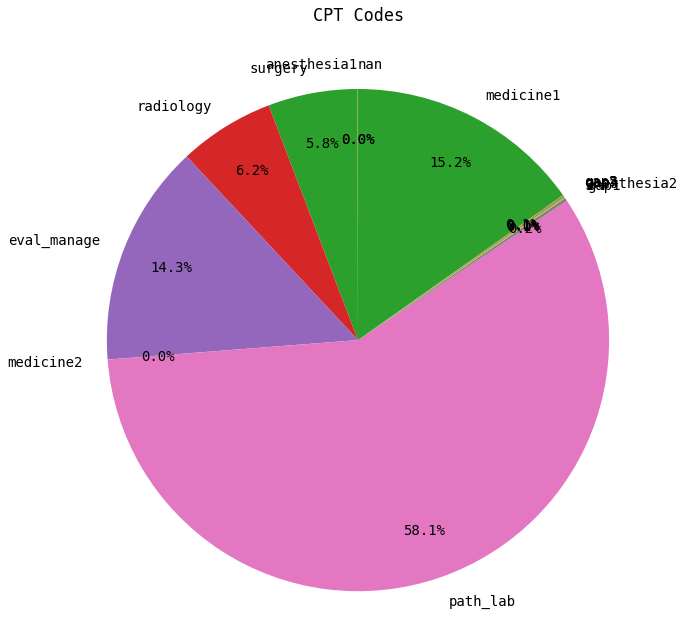

In [33]:
pie_chart(code_dict.keys(), cpt2, 'code_cat', 'CPT Codes', figsize = (10, 10))

In [60]:
icd2.head()

,ruid,icd9_code,event_date,code_num,code_cat
0,50135262,00.40,2007-08-04,0.40,proc
1,50135262,00.46,2007-08-04,0.46,proc
2,50135262,00.66,2007-08-04,0.66,proc
3,50135262,00.81,2012-09-17,0.81,proc
4,50135262,00.82,2012-09-17,0.82,proc


In [84]:
# add counts of ICD9 categories for each day/patient combination
icd_wide = icd2.copy()
icd_wide = (icd_wide.drop(columns=['icd9_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

icd_wide.head()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
50135262 1991-06-25       0.0             0.0            0.0           0.0   
         2002-02-16       0.0             1.0            0.0           0.0   
         2002-11-12       0.0             2.0            0.0           0.0   
         2002-11-17       0.0             0.0            0.0           0.0   
         2002-11-20       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
50135262 1991-06-25           2.0          0.0    0.0           0.0   
         2002-02-16           1.0          0.0    0.0           0.0   
         2002-11-12           2.0          0.0    0.0           0.0   
         2002-11-17           3.0          0.0    0.0           0.0   
         2002-11-20           1.0          0.0    0.0           0.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
50135262 1991-06-25        0.0        1.0          0.0          0.0   
         2002-02-16        0.0        0.0          0.0          0.0   
         2002-11-12        0.0        0.0          0.0          0.0   
         2002-11-17        0.0        0.0          0.0          0.0   
         2002-11-20        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
50135262 1991-06-25         0.0           0.0           0.0             0.0   
         2002-02-16         0.0           0.0           0.0             0.0   
         2002-11-12         0.0           0.0           0.0             0.0   
         2002-11-17         0.0           0.0           0.0             0.0   
         2002-11-20         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
50135262 1991-06-25      0.0          0.0   0.0    0.0  
         2002-02-16      0.0          0.0   0.0    0.0  
         2002-11-12      0.0          0.0   0.0    0.0  
         2002-11-17      0.0          0.0   0.0    0.0  
         2002-11-20      0.0          0.0   0.0    0.0

In [85]:
icd_wide.tail()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
53736422 2009-06-24       0.0             0.0            0.0           0.0   
         2009-08-27       0.0             0.0            0.0           0.0   
53736423 2006-04-23       0.0             0.0            0.0           0.0   
         2006-04-24       0.0             0.0            0.0           0.0   
         2006-04-25       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
53736422 2009-06-24           0.0          0.0    0.0           0.0   
         2009-08-27           0.0          0.0    0.0           0.0   
53736423 2006-04-23           0.0          0.0    0.0           0.0   
         2006-04-24           0.0          0.0    0.0           2.0   
         2006-04-25           0.0          0.0    0.0           1.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
53736422 2009-06-24        0.0        0.0          0.0          0.0   
         2009-08-27        1.0        0.0          0.0          0.0   
53736423 2006-04-23        0.0        0.0          0.0          0.0   
         2006-04-24        0.0        0.0          0.0          0.0   
         2006-04-25        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
53736422 2009-06-24         0.0           0.0           0.0             0.0   
         2009-08-27         0.0           0.0           0.0             0.0   
53736423 2006-04-23         0.0           0.0           1.0             0.0   
         2006-04-24         0.0           0.0           0.0             0.0   
         2006-04-25         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
53736422 2009-06-24      0.0          0.0   0.0    1.0  
         2009-08-27      0.0          2.0   0.0    0.0  
53736423 2006-04-23      0.0          0.0   1.0    2.0  
         2006-04-24      0.0          0.0   1.0    1.0  
         2006-04-25      0.0          0.0   1.0    0.0

In [0]:
icd_wide.to_pickle(dir + 'icd_wide.pkl')

In [101]:
icd_wide = pd.read_pickle(dir + './icd_wide.pkl')
icd_wide.head()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
50135262 1991-06-25       0.0             0.0            0.0           0.0   
         2002-02-16       0.0             1.0            0.0           0.0   
         2002-11-12       0.0             2.0            0.0           0.0   
         2002-11-17       0.0             0.0            0.0           0.0   
         2002-11-20       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
50135262 1991-06-25           2.0          0.0    0.0           0.0   
         2002-02-16           1.0          0.0    0.0           0.0   
         2002-11-12           2.0          0.0    0.0           0.0   
         2002-11-17           3.0          0.0    0.0           0.0   
         2002-11-20           1.0          0.0    0.0           0.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
50135262 1991-06-25        0.0        1.0          0.0          0.0   
         2002-02-16        0.0        0.0          0.0          0.0   
         2002-11-12        0.0        0.0          0.0          0.0   
         2002-11-17        0.0        0.0          0.0          0.0   
         2002-11-20        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
50135262 1991-06-25         0.0           0.0           0.0             0.0   
         2002-02-16         0.0           0.0           0.0             0.0   
         2002-11-12         0.0           0.0           0.0             0.0   
         2002-11-17         0.0           0.0           0.0             0.0   
         2002-11-20         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
50135262 1991-06-25      0.0          0.0   0.0    0.0  
         2002-02-16      0.0          0.0   0.0    0.0  
         2002-11-12      0.0          0.0   0.0    0.0  
         2002-11-17      0.0          0.0   0.0    0.0  
         2002-11-20      0.0          0.0   0.0    0.0

# Medications

In [6]:
med[:10]

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
0,50135262,02/13/2011,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650.00000 MG,Q4H PRN,NaN
1,50135262,05/23/2012,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN
2,50135262,05/23/2012,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650.00000 MG,Q4H PRN,NaN
3,50135262,10/29/2010,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,ONCE,NaN
4,50135262,10/29/2010,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650.00000 MG,ONCE,NaN
5,50135262,02/11/2011,ACETAMINOPHEN ORAL SOLUTION,NaN,NaN,PER TUBE,650 MG,Q4H PRN,NaN
6,50135262,02/26/2008,ACETAMINOPHEN: TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN
7,50135262,05/02/2012,ACETAMINOPHEN: TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN
8,50135262,11/15/2014,ACETAMINOPHEN: TYLENOL,NaN,NaN,PO,650 MG,Q6H PRN,NaN
9,50135262,11/16/2004,ACETAMINOPHEN: TYLENOL,NaN,NaN,PO,325-650 MG,Q6H PRN,NaN


In [7]:
med[-10:]

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
13544415,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.50000 """"",ONCE,NaN
13544416,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,NaN,NaN,TOPICAL,NaN,ONCE,NaN
13544417,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1 MG,ONCE,NaN
13544418,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1.00000 MG,ONCE,NaN
13544419,53736423,11/17/2014,Polysporin,ointment,NaN,NaN,NaN,NaN,NaN
13544420,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5 MCG,ONCE,NaN
13544421,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5.00000 MCG,ONCE,NaN
13544422,53736423,11/17/2014,Vyvanse,NaN,NaN,NaN,NaN,daily,NaN
13544423,53736423,11/17/2014,antibiotic,ointment,NaN,NaN,NaN,NaN,NaN
13544424,53736423,11/17/2014,tetracaine,NaN,3ml,topical,NaN,NaN,NaN


### There are significant duplicates of numeric rows (see vaccine administered at 5 and 5.00000)

In [8]:
med.describe(include='all')

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
count,1.354442e+07,13543315,13544224,3365798,8593766,9112451,4701919,8842187,918379
unique,NaN,7739,29618,791,36092,786,21372,4515,5544
top,NaN,05/07/2013,prednisone,tablet,10mg,by mouth,1 tablet,daily,24 hr
freq,NaN,7311,144952,666141,495255,2794839,1134482,1453323,87443
mean,5.362697e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.954247e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.013526e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.372981e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.373207e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.373439e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# make new columns to match api for RxNorm
med2 = med.copy()
med2.rename(columns={'drug_name': 'DrugNameWithoutDose',
                    'drug_form': 'DosageForm',
                    'dose_amt': 'StrengthText'}, 
            inplace=True)
# need to add a blank 'DrugUnit' as it's already included in 'dose_amt'
med2['DrugUnit'] = np.NaN

# remove the 5 extra 0's in StrengthText
med2['StrengthText'] = med2['StrengthText'].str.replace('.00000', '')

med2.head()

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,StrengthText,drug_freq,duration,DrugUnit
0,50135262,02/13/2011,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN,NaN
1,50135262,05/23/2012,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN,NaN
2,50135262,05/23/2012,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,Q4H PRN,NaN,NaN
3,50135262,10/29/2010,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,ONCE,NaN,NaN
4,50135262,10/29/2010,ACETAMINOPHEN : TYLENOL,NaN,NaN,PO,650 MG,ONCE,NaN,NaN


### Convert Strings to Standardized RxNorm Concept Unique Identifiers (CUIs)

In [4]:
# only needs to be run once
#DatasetCreation.structured_elements2rxcui(med2)

In [5]:
cuis = pd.read_csv(config.out_dir + 'structured_elements_to_rxcui.csv')
print(cuis.shape)
cuis.head()

(265850, 41)


,unique_combo,rxcui1,rxcui2,rxcui3,rxcui4,rxcui5,rxcui6,rxcui7,rxcui8,rxcui9,...,rxcui31,rxcui32,rxcui33,rxcui34,rxcui35,rxcui36,rxcui37,rxcui38,rxcui39,rxcui40
0,ACETAMINOPHEN : TYLENOL 650 MG,608663.0,315268.0,608680.0,615914.0,198443.0,569998.0,569974.0,569975.0,570070.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACETAMINOPHEN ORAL SOLUTION 650 MG,315268.0,370506.0,198444.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACETAMINOPHEN: TYLENOL 650 MG,608663.0,315268.0,608680.0,615914.0,198443.0,569998.0,569974.0,569975.0,570070.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACETAMINOPHEN: TYLENOL 325-650 MG,315268.0,209387.0,569998.0,646457.0,1738139.0,315263.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGITATION SEDATION SCORE,1544611.0,283760.0,1544242.0,1482548.0,1543925.0,1596247.0,1552120.0,1547067.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert RxNorm CUIs to MeSH Drug Classes

In [18]:
# only needs to be run once
#DatasetCreation.cui2class(cuis)

In [19]:
# load classes corresponding to each cui
classes = pd.read_csv(config.out_dir + 'cui2class.csv')
print(classes.shape)
# drop rows with no corresponding categories (i.e., must contain rxcui & at least 1 category)
classes.dropna(thresh=2, inplace=True)
print(classes.shape)
classes.head()

(58397, 18)
(31372, 18)


/Users/AlvinMBA/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
5,38,Dopamine Agonists,Antiparkinson Agents,Hormone Antagonists,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,44,Protective Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,94,"Antidepressive Agents, Second-Generation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,97,Fibrinolytic Agents,Cytochrome P-450 CYP2C19 Inhibitors,Purinergic P2Y Receptor Antagonists,Platelet Aggregation Inhibitors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,99,Antifibrinolytic Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
classes.tail()

,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
58235,2059052,"Anti-Infective Agents, Local",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58237,2059178,Keratolytic Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58244,2059297,"Anti-Infective Agents, Local",Disinfectants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58394,2099131,"Anesthetics, Local",Contrast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58395,2099327,Bone Density Conservation Agents,Vitamins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
import importlib
importlib.reload(DatasetCreation)
importlib.reload(config)
importlib.reload(api_rxnorm)

<module 'api_rxnorm' from '/Volumes/AlvinSD/Bios8366_project/code/api_rxnorm.py'>

In [21]:
# most common drug classes
classes.describe(include='all')

,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
count,3.137200e+04,31372,22424,13537,6867,3737,2478,1114,839,323,147,115,83,46,22,13,2,1
unique,NaN,287,242,175,139,96,65,52,35,24,16,14,10,9,7,4,2,1
top,NaN,Vasodilator Agents,Anti-Inflammatory Agents,Antihypertensive Agents,Bronchodilator Agents,Histamine H1 Antagonists,Sympathomimetics,Sympathomimetics,Antiemetics,Sympathomimetics,Nasal Decongestants,Antitussive Agents,Excitatory Amino Acid Antagonists,Parasympatholytics,Anticonvulsants,Hematinics,Anticonvulsants,Hematinics
freq,NaN,1145,1087,694,353,242,324,149,115,64,31,25,20,20,10,10,1,1
mean,8.433718e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.210417e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.800000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.658665e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.571295e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.179318e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
